# Adaptive Exponential Integrate-and-Fire Model as an Effective Description of Neural Activity

## Romain Brette and Wulfram Gerstner, 2005

### Presentation and simulation by Louis, Linda and Hector (Master's students at ENS, Paris) 2020

$\textbf{SOP}$

The goals of the paper are :
1. To develop a 2D adaptive exponential integrate-and-fire model (exponential spike mechanism + an adaptation equation).
2. Estimate its paramaters with a systematic method.
3. Apply to a detailed conductance-based model of regular spiking neuron.


The goals of our analysis of the paper are :
1. To reproduce faithfully the simulation of the spiking neuron
2. Reproduce same performance of prediciton, especially in high-conductance states
3. Asses how many electrophysiological classes are well described in vitro by this model, if not, why and how we can modify it to perform better or be applied to more neuronal behaviors.


Here I try to summary the paper and point out its most unclear points.

In [12]:
#Libraries
import numpy as np
import numpy.matlib
import brian2

In [13]:
#Graphic
import matplotlib.pyplot as plt
width_in_inches = 12
height_in_inches = 8
dots_per_inch = 70

In [14]:
#plt.rcParams["figure.figsize"] = (15, 7)
#plt.rc('xtick',labelsize=20)
#plt.rc('ytick',labelsize=20)

title_fontsize = 36
ax_fontsize = 18
label_fontsize = 20

## 1. Model introduction

$\textbf{Introdution}$

Trying to go beyong the tradition LIF model : quadratic or exponential, inclusion of subthreshold resonances (adaptation), change the stimulation paradigm from current injection to conductance injection (closer to in vivo conditions).

20 simulaitons of 15 seconds in NEURON with different set of parameters.

We introduce the aEIF model :

$$C \frac{dV}{dt} =f(V) - w + I $$

$$ r = h(I) $$

In [15]:
def V_deriv(V_prev,w_now,input_current,parameters):
    
    V_new = (1/parameters['C'])*(potential_to_current(V_prev, parameters) - w_now + input_current)
    return V_new

where C is the membrane capacitance, f(V) is a function that cjracterizes the passive properties and the spiking mechanism, w is an adaptaion variable, and I is the synaptic current.

And $$ f(V) = - g_L (V - E_L) + g_L \Delta_T exp(\frac{V - V_T}{\Delta_T}) $$

In [16]:
def potential_to_current(V, parameters):
    return - parameters['g_L']*(V - parameters['E_L']) + parameters['g_L']*parameters['Delta_T']*np.exp((V - parameters['V_T'])/parameters['Delta_T'])

where $g_l$ is th eleak conductance, $E_L$ is the resting potential,$\Delta_T$ is the slope factr, and $V_T$ is the threshold potential.

At spike time (when $V > V_{peak} = 20 mV$), $ V \mapsto E_L $ and $ w \mapsto w + b $

The adaptation current w is defined by:

$$\tau_w \frac{dw}{dt} =a (V - E_L) - w$$

In [17]:
def w_deriv(w_prev,V_now,parameters):
    
    w_new = (1/parameters['tau_w'])*(parameters['a']*(V_now - parameters['E_L']) - w_prev)
    return w_new

where $\tau_w$ is the time constant and $a$ represents the level of subthreshold adaptation.

Finally, the current $I$ is given by :

   $$ I = I_{AMPA} + I_{GABA} + I_{ext} + I_{noise} $$
   
   Where $ I_{AMPA} $ in an AMPA-dependent excitatory current, $ I_{GABA} $ is a GABA-dependent inhibitory current, $ I_{ext} $ is the injected current, and $ I_{noise} $ a random Gaussian number.
   
   Furthermore, we have : 
   
   $$ I_{AMPA} = - g_e(t)(V - E_e) $$
  $$ I_{GABA} = -g_i(t)(V - E_i)$$
   
   Where $ E_e $ and $ E_i $ are the reversal potentials for the AMPA and GABA currents (respectively). $ g_e(t) $ and  $ g_i(t) $ are respectively the AMPA and GABA conductances and are described by Ornstein-Uhlenbeck processes with respective time constants $ t_e = 2.728 ms $ and $ t_i = 10.49 ms $. 

As laid out in Destexhe et al., 2001 :
$$ \frac{dg_e(t)}{dt} = - \frac{1}{\tau_e}[g_e(t) - g_{e0}] + \sqrt{D_e}\chi_1(t) $$
 $$   \frac{dg_i(t)}{dt} = - \frac{1}{\tau_i}[g_i(t) - g_{i0}] + \sqrt{D_i}\chi_2(t) $$
    
Where $g_{e0} $ and $ g_{i0}$ are average conductances (the mean conductances given in Table 1, simply named $g_e$ and $g_i$ in the Brette & Gerstner), $D_e$ and $D_i$ are noise 'diffusion' coefficients, and $\chi_1(t)$ and $\chi_2(t)$ are Gaussian white noise of zero mean and unit standard deviation.

The update rule for those processes is given by
$$g_e(t+h) = g_{e0} + [g_e(t) - g_{e0}]exp(-\frac{h}{\tau_e}) + A_eN_1(0,1) $$
$$   g_i(t+h) = g_{i0} + [g_i(t) - g_{i0}]exp(-\frac{h}{\tau_i}) + A_iN_2(0,1) $$
   
$ N_i(0, 1) $ and $ N_2(0, 1) $ are normal random numbers (zero mean, unit SD). $ A_e $ and $A_i$ are amplitude coefficients given by :

$$ A_e = \sqrt{\frac{D_e\tau_e}{2}[1-exp(\frac{-2h}{\tau_e})]} $$
$$    A_i = \sqrt{\frac{D_i\tau_i}{2}[1-exp(\frac{-2h}{\tau_i})]}$$

Finally, the diffusion coefficients are given by :
$$D = \frac{2\sigma^2}{\tau}$$

In [18]:
def update_g(g_prev, g_type, parameters):
    
    if g_type =='AMPA':
        g_new = parameters['g_AMPA'] + (g_prev - parameters['g_AMPA'])*np.exp(-parameters['dt']/parameters['tau_AMPA']) \
        + parameters['A_AMPA']*np.random.normal(loc=0.0,scale=1.0)
        
    elif g_type == 'GABA':
        g_new = parameters['g_GABA'] + (g_prev - parameters['g_GABA'])*np.exp(-parameters['dt']/parameters['tau_GABA']) \
        + parameters['A_GABA']*np.random.normal(loc=0.0,scale=1.0)
    
    else :
        raise ValueError('g_type must be either AMPA or GABA')
    
    return g_new

## 2. Fitting the parameters

In first approximation, we take the parameters as fixed in the paper without any supplementary counter-analysis. Later one, we could fit these parameters by ourselves, but this approach is less interesting to us now, compared to simulating the aEIF correctly.

In [161]:
parameters = {}
    
# Physiological parameters
parameters.update({ # Conductance
                    'C' : 281 *brian2.pF,
                    'g_L' : 30 * brian2.nS,
                    'g_AMPA': 1/2 * brian2.nS,
                    'g_GABA': 2/3 * brian2.nS,
                    'sigma_AMPA': 1/3 * brian2.nS,
                    'sigma_GABA' : 2/3 * brian2.nS,
                    # Reverse potential
                    'E_L' : - 60 * brian2.mV, #V_reset
                    'E_AMPA' : 0 * brian2.mV,
                    'E_GABA' : - 75 * brian2.mV,
                    # Spike threshold
                    'V_T' : - 50.4 * brian2.mV,
                    'Delta_T' : 2 * brian2.mV,
                    'V_th' : 20 * brian2.mV,
                    'V_reset' : -60 * brian2.mV,
                    # Time constants
                    'tau_w': 720  * brian2.ms,   
                    'tau_AMPA' : 2.728 * brian2.ms,
                    'tau_GABA' : 10.49 * brian2.ms,
                    # Adaptation constants
                    'a': 80  * brian2.nS,    
                    'b': 0.0805  * brian2.nA})
    
# Time
parameters.update({'dt': 0.5 * brian2.ms}) 
parameters.update({'trial_length': 1 * brian2.second,
                   'start_time': 0 *brian2.second, 
                   'end_time': 1 *brian2.second}) 
    
# Initial Conditions
parameters.update({'V_0' : -60 * brian2.mV,
                   'w_0' : 0 * brian2.nA})

# Plotting 
parameters.update({'y_min' : -100 * brian2.mV,
                   'y_max' : 0 * brian2.mV})

Here we define Table 1.

In [206]:
G_LC =  np.array([[1/3, 2/3, 1/3, 2/3],[1/3, 2/3, 1/2, 2/3], [1/2, 1/2, 1/2, 1], [1/2, 1/2, 2/3, 1],[1/2, 1/2, 1, 1]]) 

G_MC =  np.array([[1/2, 3/2, 1/2, 2/3],[2/3, 4/3, 1/3, 1], [2/3, 4/3, 1/2, 1], [1/2, 3/2, 1, 1],[2/3, 4/3, 1, 2]]) 

G_HC =  np.array([[1, 3, 1/2, 1],[1, 3, 2/3, 4/3], [1, 3, 1, 1], [1, 3, 1, 2],[4/3, 8/3, 2/3, 2]])

G_tot = np.array([[[1/3, 2/3, 1/3, 2/3],[1/3, 2/3, 1/2, 2/3], [1/2, 1/2, 1/2, 1], [1/2, 1/2, 2/3, 1],[1/2, 1/2, 1, 1]],[[1/2, 3/2, 1/2, 2/3],[2/3, 4/3, 1/3, 1], [2/3, 4/3, 1/2, 1], [1/2, 3/2, 1, 1],[2/3, 4/3, 1, 2]],[[1, 3, 1/2, 1],[1, 3, 2/3, 4/3], [1, 3, 1, 1], [1, 3, 1, 2],[4/3, 8/3, 2/3, 2]]])

G_null = np.array([[0, 0, 0, 0]]) 

### 2.5. Performance measures

We introduce two objective paramaters :
     $W$ : percentage of missing spikes and
     $E$ : percentage of extra spikes.
And we obtain at low values of this estimator, a single performance measure, which is the coincidence factor $\Gamma$ (Kistler et al., 1997) :
    $$ \Gamma = 1 - (E + M)/2 $$

In [204]:
def convert_spike_list_to_windows(A):
    L = []
    for a in A:
        L.append(a-0.002)
        L.append(a+0.002)
    return L

In [222]:
def merge_list(A,B):
    len_A = len(A)
    len_B = len(B)
    new_list = np.zeros((len_A+len_B,2))
    for i in range(len_A):
        new_list[i][0] = A[i]
        new_list[i][1] = 1 #meaning from A (aEIF)
    for i in range(len_B):
        new_list[len_A+i][0] = B[i]
        new_list[len_A+i][1] = 0 #meaning from B (ref)
    return sorted(new_list,key=lambda x: x[0])

In [223]:
A = [0,2,6,8,10,12]
B = [0,1.8,6,7,10,13]

In [224]:
E_and_M(A,B)

[array([0., 1.]),
 array([0., 0.]),
 array([1.8, 0. ]),
 array([2., 1.]),
 array([6., 1.]),
 array([6., 0.]),
 array([7., 0.]),
 array([8., 1.]),
 array([10.,  1.]),
 array([10.,  0.]),
 array([12.,  1.]),
 array([13.,  0.])]

In [ ]:
def E_and_M(A,B):
    L = merge_list(A,B)
    E = 0
    M = 0
    open_model = 0
    close_model = 0
    opne_ref = 0
    close_ref = 0
    for i in range(len(L)):
        key = L[i][1]
        if i%2==0:
            if key ==1:
                open_model = L[i][0]
            else:
                open_ref = L[i][0]
        else:
            if key ==1:
                close_model = L[i][0]
            else:
                close_ref = L[i][0]

In [162]:
def coincidence(E, M):
    return 1 - (E + M)/2

## 3. Simulations

Simulation and analysis are done with Python on a Jupyter environment on a portable PC.

In [195]:
class Model(object,):
    def __init__(self, parameters,n_trial=1):
        self.parameters = parameters.copy()       # Model parameters
        self.n_trial = n_trial

    def run(self):
        self.__init__(self.parameters)
       
        # Set up simulation parameters
        self.dt= self.parameters['dt']   # timestep 
        self.num_iterations = int(self.parameters['trial_length']/self.dt)
        num_iterations =  self.num_iterations
        time = np.arange(0, self.parameters['trial_length'], self.parameters['dt'])

        # Choose initial values for potential and adaptation variables
        self.V_0 = self.parameters['V_0']
        self.w_0 = self.parameters['w_0']
        
        # Preassign potential and adaptation matrices
        self.V = np.zeros((num_iterations)) * brian2.mV
        self.V[0] = self.V_0
        self.w = np.zeros((num_iterations)) * brian2.nA
        self.w[0] = self.w_0
        
        # Choose stimulus strength
        stim_strength = self.parameters['stim_strength']
        self.stim_on    = self.parameters['stim_on'] 
        self.stim_off   = self.parameters['stim_off']
        stim_strength2 = self.parameters['stim_strength2']
        self.stim_on2    = self.parameters['stim_on2'] 
        self.stim_off2   = self.parameters['stim_off2']
        
        # Preassign external inputs
        I_ext      = np.zeros((num_iterations,1)) * brian2.amp
        I_ext[int(self.stim_on/self.dt):int(self.stim_off/self.dt),0] = stim_strength
        I_ext[int(self.stim_on2/self.dt):int(self.stim_off2/self.dt),0] = stim_strength2
    
        # Create matrices in which we can store the currents
        I_AMPA =  np.zeros((num_iterations)) * brian2.pA
        I_GABA =  np.zeros((num_iterations)) * brian2.pA
        
        # Define the total current I
        self.I_total =  np.zeros((num_iterations)) * brian2.pA
        
        # Define noise 
        I_noise = 0 * brian2.pA
        
        # Spike list
        self.spike_list = []
        
        # Compute diffusion coefficients for each conductance
        self.parameters.update({'D_AMPA':(2*self.parameters['sigma_AMPA']**2)/self.parameters['tau_AMPA'],
                                'D_GABA':(2*self.parameters['sigma_GABA']**2)/self.parameters['tau_GABA']})
        
        # Compute amplitude coefficients for each conductance 
        self.parameters.update({'A_AMPA':np.sqrt(((self.parameters['D_AMPA']*self.parameters['tau_AMPA'])/2) * (1-np.exp((-2*self.dt)/self.parameters['tau_AMPA']))),
                                'A_GABA':np.sqrt(((self.parameters['D_GABA']*self.parameters['tau_GABA'])/2) * (1-np.exp((-2*self.dt)/self.parameters['tau_GABA'])))})
        
        # Set the initial conductances : 
        g_AMPA = self.parameters['g_AMPA']
        g_GABA = self.parameters['g_GABA']
        
        for i_t in range(1,num_iterations):
            
            # AMPA
            I_AMPA[i_t-1] = - g_AMPA*(self.V[i_t-1] - self.parameters['E_AMPA'])
            # GABA_A 
            I_GABA[i_t-1] = - g_GABA*(self.V[i_t-1] - self.parameters['E_GABA'])
            # Define total input current 
            self.I_total[i_t-1] = I_AMPA[i_t-1] + I_GABA[i_t-1] + I_ext[i_t-1] + I_noise
            
            # Update the conductances 
            g_AMPA = update_g(g_AMPA, 'AMPA', self.parameters)
            g_GABA = update_g(g_GABA, 'GABA', self.parameters)

            # Update the adaptation current
            if self.V[i_t-1] > self.parameters['V_th']:
                self.w[i_t] = self.w[i_t-1] + self.parameters['b']
                self.V[i_t] =  self.parameters['V_reset']
                self.spike_list.append((i_t-1)/self.num_iterations)
            else:
                self.w[i_t] = self.w[i_t-1] + self.dt*w_deriv(self.w[i_t-1],self.V[i_t-1],self.parameters)
                # Update the potential of the two excitatory populations.
                self.V[i_t] = self.V[i_t-1] + self.dt*V_deriv(self.V[i_t-1],self.w[i_t], self.I_total[i_t-1],self.parameters)

    def draw(self,):
        self.__init__(self.parameters)
        
        fig=plt.figure(figsize=(24,8), dpi= 80, facecolor='w', edgecolor='k')
        plt.rcParams.update({'font.size': 12})
        ax = plt.subplot(1,2,1)
        plt.subplots_adjust(hspace = 1)
        # Plot the potential
        # plt.plot(np.arange(self.parameters['start_time'],self.parameters['end_time'],self.dt),self.V[np.arange(int(self.parameters['start_time'].item()/self.dt),int(self.parameters['end_time'].item()/self.dt),1)],label = 'V')
        plt.plot(np.arange(self.parameters['start_time'],self.parameters['end_time'],self.dt),self.V,label = 'V')
        # Plot the adaptation current
        #plt.plot(np.arange(self.parameters['start_time'],self.parameters['end_time'],self.dt),self.w[np.arange(int(self.parameters['start_time'].item()/self.dt),int(self.parameters['end_time'].item()/self.dt),1)],label = 'w')
        axes = plt.gca()
        plt.axvspan(self.stim_on,self.stim_off, alpha=0.1,color='g')
        plt.axvspan(self.stim_on2,self.stim_off2, alpha=0.1,color='r')
        plt.xlabel('time (s)')
        plt.ylabel('Potential (mV)')
        plt.ylim(-0.01, 0)
        plt.yticks(np.arange((self.parameters['y_min'] / brian2.mV) / 1000, (self.parameters['y_max'] / brian2.mV) / 1000, 0.02), 
                   np.arange(self.parameters['y_min'] / brian2.mV, self.parameters['y_max'] / brian2.mV, 20))
        #plt.legend()
        plt.show()
        
    def draw_V_I(self,):
        self.__init__(self.parameters)
        I_ext      = np.zeros((self.num_iterations,1)) * brian2.amp
        I_ext[int(self.stim_on/self.dt):int(self.stim_off/self.dt),0] = self.parameters['stim_strength']
        
        fig, axes = plt.subplots(1,2,figsize=(35,8))
        time_abs = np.arange(p_1['start_time'],p_1['end_time'],self.dt)
        axes[0].plot(time_abs,V,lw=2)
        axes[0].set_xlabel(r"$t$ (s)", fontsize=ax_fontsize)
        axes[0].set_ylabel(r"$V$ (V)", fontsize=ax_fontsize)
        axes[0].set_ylim([-0.0060, -0.002])
        #axes[0].legend(fontsize=label_fontsize,loc=(1.04,0))

        axes[1].plot(time_abs,I_ext,lw=2)
        axes[1].set_xlabel(r"$t$ (s)", fontsize=ax_fontsize)
        axes[1].set_ylabel(r"$I$ (nA)", fontsize=ax_fontsize)
        axes[1].set_ylim([-0.1,1])
        #axes[1].legend(fontsize=label_fontsize,loc=(1.04,0))
        plt.show()
          
        
    def extract_V(self,):
        self.__init__(self.parameters)
        return self.V
    
    def extract_spike_list(self,):
        self.__init__(self.parameters)
        return self.spike_list

## 4. Results

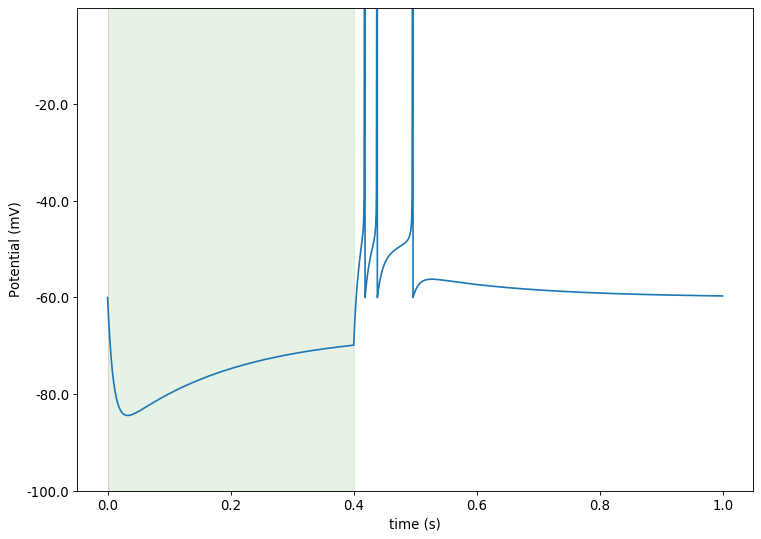

In [199]:
parameters.update({'stim_on': 0 * brian2.second,
                'stim_off': 0.4 *brian2.second,
            'stim_strength': -0.8 *brian2.nA  })
parameters.update({'stim_on2': 0 * brian2.second,
                'stim_off2': 0 *brian2.second,
            'stim_strength2': 0 *brian2.nA  })
g = G_null[0]
g = g * parameters['g_L']
parameters.update({'g_AMPA': g[0],
                    'g_GABA': g[1],
                    'sigma_AMPA': g[2],
                    'sigma_GABA' : g[3]}) 
model_1 = Model(parameters)
model_1.run()
fig = model_1.draw()

In [203]:
print(model_1.extract_spike_list())
l = model_1.extract_spike_list()

[0.418, 0.438, 0.496]


In [205]:
convert_spike_list_to_windows(l)

[0.416, 0.42, 0.436, 0.44, 0.494, 0.498]

In [168]:
def V_g(g):
    p_1 = parameters.copy()
    g = g * p_1['g_L']
    p_1.update({'g_AMPA': g[0],
                    'g_GABA': g[1],
                    'sigma_AMPA': g[2],
                    'sigma_GABA' : g[3]}) 
    model_1 = Model(p_1)
    model_1.run()
    return model_1.extract_V()

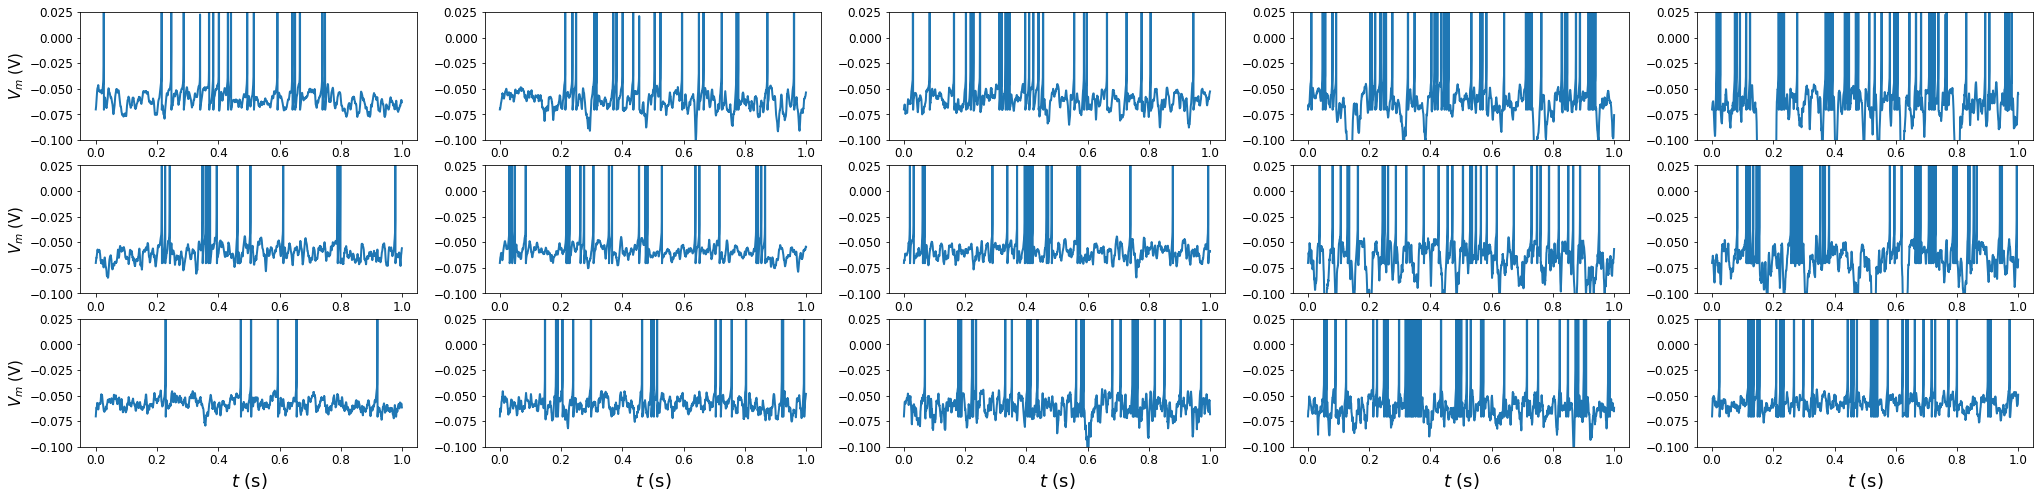

In [115]:
fig, axes = plt.subplots(3,5,figsize=(35,8))
p_1 = parameters.copy()
p_1.update({'stim_on': 0.2 * brian2.second,
                'stim_off': 0.2 * brian2.second,
            'stim_strength': 0
                      })

for i in range(3):
    G = G_tot[i]
    for j in range(5):
        g = G[j]
        V = V_g(g)
        time_abs = np.arange(p_1['start_time'],p_1['end_time'],model_1.dt)
        axes[i][j].plot(time_abs,V,lw=2,label=r"$g_{AMPA} = "+str(round(g[0],2))+",g_{GABA} = "+str(round(g[1],2))+",\sigma_{AMPA} = "+str(round(g[2],2))+",\sigma_{GABA} = "+str(round(g[3],2))+"$")
        axes[i][j].set_xlabel(r"$t$ (s)", fontsize=ax_fontsize)
        axes[i][0].set_ylabel(r"$V_m$ (V)", fontsize=ax_fontsize/1.2)
        #axes[i][j].set_title(r"$g_{AMPA} = "+str(round(g[0],2))+",g_{GABA} = "+str(round(g[1],2))+",\sigma_{AMPA} = "+str(round(g[2],2))+",\sigma_{GABA} = "+str(round(g[3],2))+"$", fontsize=ax_fontsize)
        axes[i][j].set_ylim([-0.1,.025])
        #axes[i][j].legend(fontsize=label_fontsize)
plt.show()

### 4.1 Comparison to the reference models (montrer qu'on est meilleur que le modèle de référence)

### 4.2 Relevance of model components (faire joujou avec les paramètres, changer les équations)

### 4.3 Reliability of the model in a noisy setting (introduire du bruit pour faire genre on est proche de la réalité)

## 5. Discussion

Compare witht he Izhikevich model (regular spiking, bursting, chattering)

In [13]:
np.random.normal(loc=0.0, scale=1.0)

0.6476344214255164